In [6]:
pip install numpy


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 14.9 MB/s eta 0:00:0031m12.1 MB/s eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 15.6 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.2 MB/s eta 0:00:00 MB/s eta 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib] 6/7 [matplotlib]ow]
Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [8]:
import math
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


In [9]:
def f(x):
    return 3*x**2 - 4*x + 5

In [10]:
f(3.0)

20.0

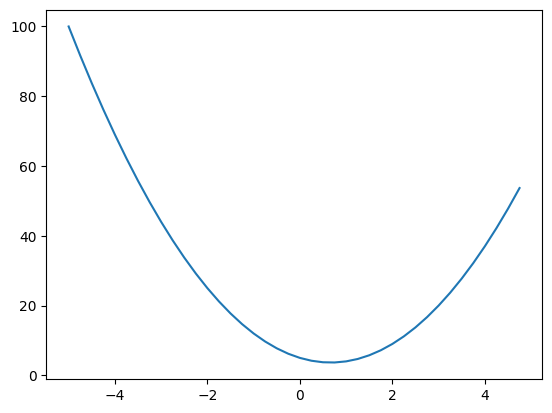

In [13]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [164]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self._backward = lambda: None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+") 
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be an integer or float"
        out = Value(self.data ** other, (self,), f"**{other}")
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), "tanh")
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()

a = Value(3.0, label='a')
b = Value(-3.0, label='b') 
c = Value(-9.0, label='c')
e = a+b; e.label = 'e'
d = a*b+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
d

Value(data=-18.0)

In [166]:
a - (-b)

Value(data=0.0)

In [147]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    for n in nodes:
        uid = str(id(n))
        # Use curly braces for record shape
        dot.node(name=uid, label=f"{{ {n.label} | data: {n.data:.4f} | grad: {n.grad:.4f} }}", shape='record')

        if n._op:
            dot.node(name=uid + n._op, label=n._op, shape='circle')
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [148]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


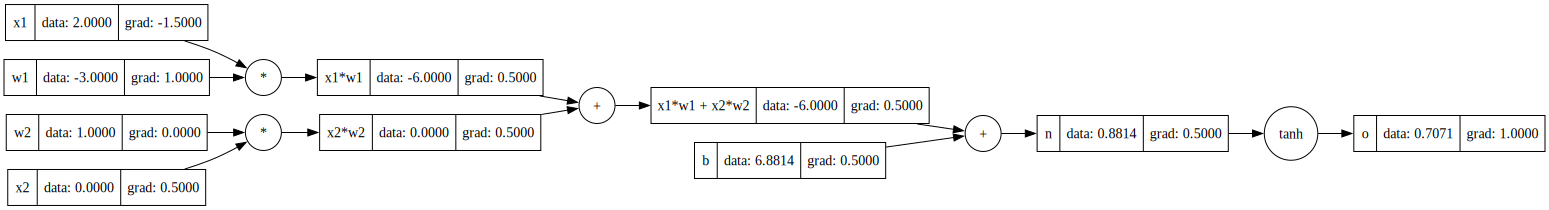

In [151]:
draw_dot(o)

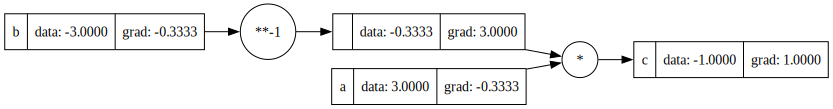

In [163]:
o.backward()

a = Value(3.0, label='a')
b = Value(-3.0, label='b')

c = a / b # c = a * b**-1
c.label = 'c'

c.backward()
draw_dot(c)